# Sprint 2

We will start by loading in all the images

In [6]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

IMG_HEIGHT = 128
IMG_WIDTH = 128
img_folder = r'tripadvisor_dataset/tripadvisor_images/'

def create_dataset(img_folder, n=None):
    wrong_data = 0
    img_data_array = []
    files = os.listdir(os.path.join(img_folder))

    if n is None:
        n = len(files)
    
    counter = 0
    for file in files:
        #print(file)
        if counter == n:
            break
        try:
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)[..., ::-1] # convert BRG to RGB
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image = np.array(image).flatten()
            if len(image) == IMG_HEIGHT*IMG_WIDTH*3:
                image = image.astype('float32')
                image /= 255
                img_data_array.append(image)
            else:
                wrong_data += 1

        except Exception as e:
            print("file", file, "could not process:", e)
        counter += 1
    
    print("There are", wrong_data, "images that are too small.")

    return np.array(img_data_array)





In [7]:

images = create_dataset(img_folder, 2000)


# import tensorflow as tf
# data_dir ='tripadvisor_dataset/tripadvisor_images/' 
# image = train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(128, 128))


file .DS_Store could not process: 'NoneType' object is not subscriptable
There are 3 images that are too small.


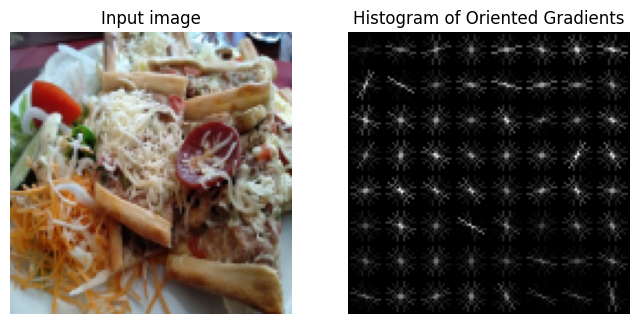

In [8]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# plt.imshow(images[0].reshape((128,128,3)))
img = images[0].reshape(IMG_HEIGHT,IMG_WIDTH,3)

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [54]:
images_hogs = np.zeros((images.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images), total=len(images)):
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel], orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_hogs[i, channel*512:channel*512+512] = fd


100%|██████████| 1996/1996 [00:34<00:00, 58.53it/s]


In [57]:
images_hogs

array([[0.40597931, 0.17340122, 0.43869033, ..., 0.27691481, 0.50615233,
        0.50615233],
       [0.48363426, 0.30857196, 0.22845609, ..., 0.28633887, 0.35412157,
        0.36971495],
       [0.91431987, 0.00625244, 0.01802353, ..., 0.43177226, 0.43177226,
        0.43177226],
       ...,
       [0.54638016, 0.54638016, 0.09893525, ..., 0.43131655, 0.43349263,
        0.03851487],
       [0.43639073, 0.08126236, 0.36567435, ..., 0.19233693, 0.29474396,
        0.05597327],
       [0.05668189, 0.01645097, 0.04727347, ..., 0.07855845, 0.06313642,
        0.08008686]])

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from yellowbrick.cluster import silhouette_visualizer
from sklearn.cluster import KMeans

# scale hog features
sc = StandardScaler()
hogs_scaled = sc.fit_transform(images_hogs)

kpca = KernelPCA(n_components=90, kernel='cosine')
transformed = kpca.fit_transform(hogs_scaled)



In [76]:
kmeans2 = KMeans(n_clusters=20, random_state=0)
predictions = kmeans2.fit_predict(transformed)

# silhouette_visualizer(kmeans2, transformed)

CLUSTER 0


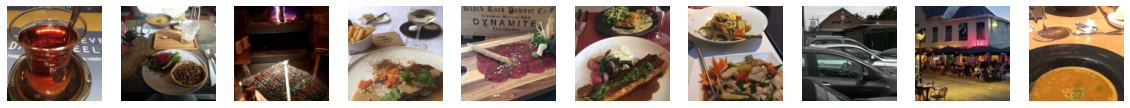

CLUSTER 1


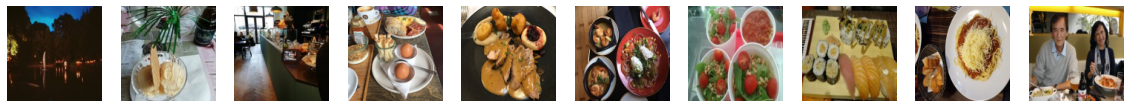

CLUSTER 2


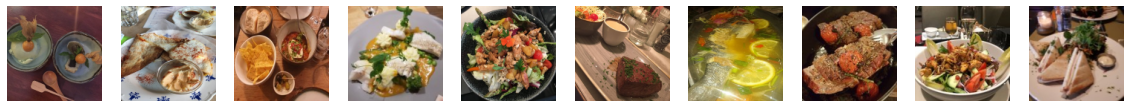

CLUSTER 3


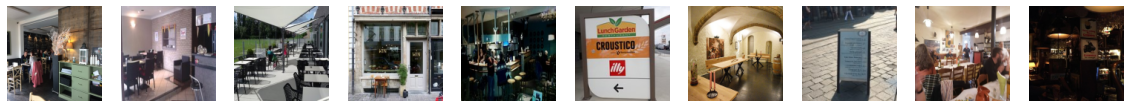

CLUSTER 4


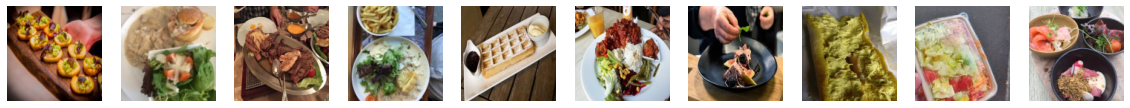

CLUSTER 5


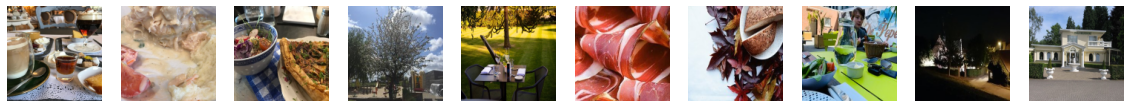

CLUSTER 6


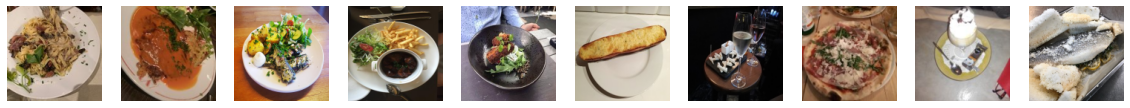

CLUSTER 7


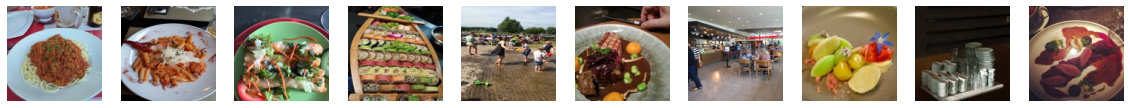

CLUSTER 8


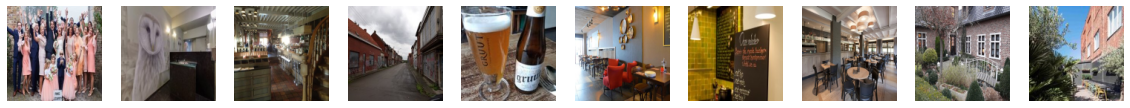

CLUSTER 9


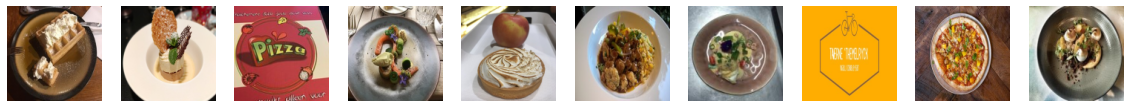

CLUSTER 10


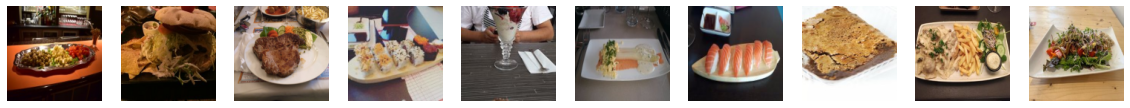

CLUSTER 11


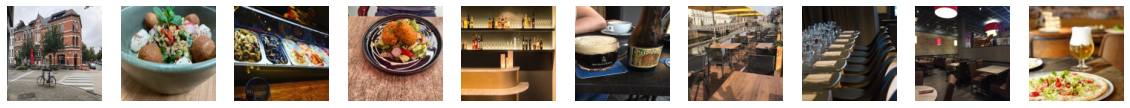

CLUSTER 12


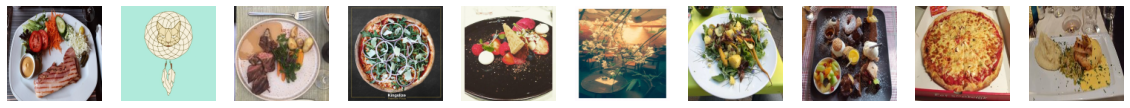

CLUSTER 13


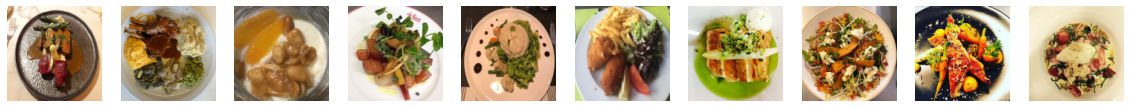

CLUSTER 14


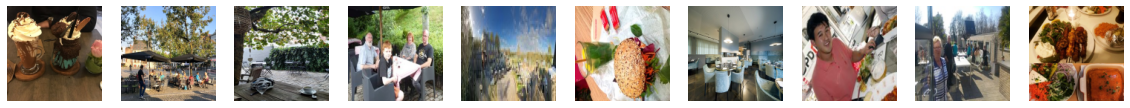

CLUSTER 15


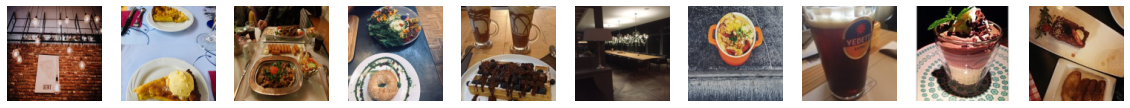

CLUSTER 16


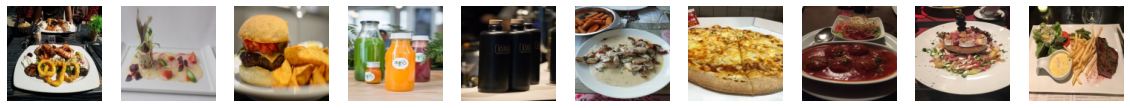

CLUSTER 17


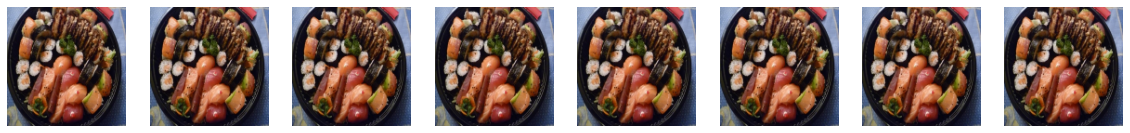

CLUSTER 18


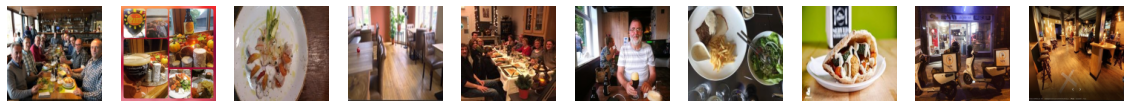

CLUSTER 19


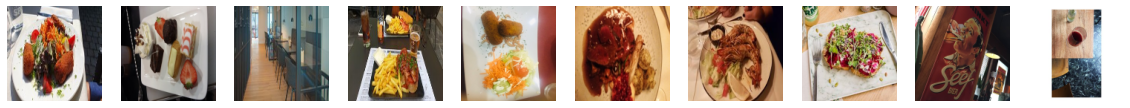

In [77]:
# you can optionally give this function the distances of the instances to the cluster centers (obtainable by using the models transform function)
def show_predictions(predictions, n_clusters, images, distances=None):
    for cluster in range(n_clusters):
        print(f"CLUSTER {cluster}")

        cluster_images = images[np.where(predictions == cluster)]

        if distances is not None:
            # we sort the images so that they are displayed in order of distance to cluster center
            cluster_distances=  np.min(distances[np.where(predictions == cluster)], axis=1)
            cluster_instances_sorted = np.argsort(cluster_distances)
            cluster_images = cluster_images[cluster_instances_sorted[::-1]]
                
        num_pics = 10 if cluster_images.shape[0] > 10 else cluster_images.shape[0]

        # try to pick out images closes to the cluster centers
        if num_pics == 0:
            print("No images in this cluster")
            continue
        if num_pics == 1:
            plt.figure()
            plt.imshow(cluster_images[0].reshape((128,128,3)))
            plt.axis("off")
            plt.show()
            continue
        indices = np.random.choice(np.arange(cluster_images.shape[0]), num_pics, replace=False)
        _, axs = plt.subplots(1, num_pics, figsize=(20,20))
        axs = axs.flatten()
        for img, ax in zip(cluster_images[indices], axs):
            ax.imshow(img.reshape((128,128,3)))
            ax.set_axis_off()
        plt.show()

show_predictions(predictions, 20, images)

The result after clustering on the HOG images is not desirable. The histogram of gradients maybe isn't the best way to cluster dishes. In the next step we will try out other feature extraction techniques and compare them by visual result and on the silhouette score and plot.

## SIFT (Scale-Invariant Featue Transform)
SIFT is a computer vision algorithm that detects and describes local features in images. The result of the SIFT features is that the detection is invariant to scale and rotation. This can be handy because we can see that the dishes are twisted and turned in all possible directions.

The algorithm proceeds as follows:

    * Scale-space peak selection: Potential location for finding features
    * Keypoint Localization: Accurately locating the feature keypoints
    * Orientation Assignment: Assigning orientation to keypoints
    * Keypoint descriptor: Describing the keypoints as a high dimensional vector
    * Keypoint Matching
  
source: https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40

Number of Keypoints Detected In The Training Image:  130
Number of Keypoints Detected In The Query Image:  130


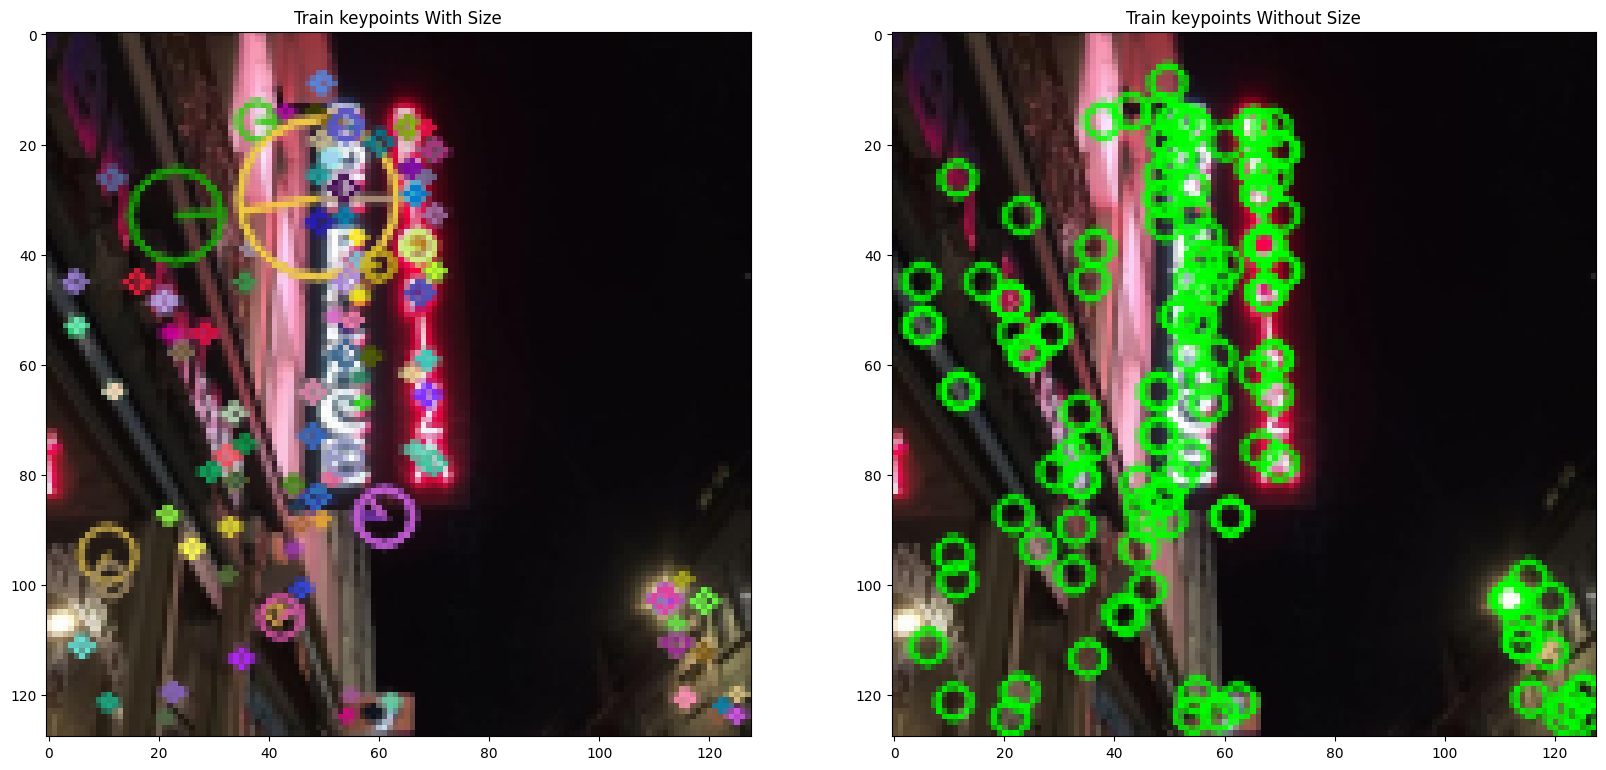

In [42]:
import cv2
sift = cv2.xfeatures2d.SIFT_create()

img = images[1].reshape(IMG_HEIGHT,IMG_WIDTH,3)

# SIFT function only accepts images with 8 bit integer values
image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Convert the training image to gray scale
training_gray = cv2.cvtColor(image8bit, cv2.COLOR_RGB2GRAY)


train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(training_gray, None)

keypoints_without_size = np.copy(image8bit)
keypoints_with_size = np.copy(image8bit)

cv2.drawKeypoints(image8bit, train_keypoints, keypoints_without_size, color = (0, 255, 0))
cv2.drawKeypoints(image8bit, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

In the pictures you can see examples of keypoints of the keypoint descriptor of SIFT. Keypoints between two different images can be matched by identifying their nearest neighbours. We will use the Kmeans algorithm of sklearn to compare them.

In [60]:
# images_SIFT = np.zeros((images.shape[0], 512 * 3))
# for img in images:
#     img = img.reshape((128,128,3))
#     image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8') 
#     training_gray = cv2.cvtColor(image8bit, cv2.COLOR_RGB2GRAY)
#     train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)


print(train_keypoints[0])
train_keypoints[0].pt
# images_hogs

< cv2.KeyPoint 0000017FB5A44750>


(4.763646125793457, 66.72151184082031)

```
hoe opencv keypoints naar numpy array omzetten?
```